In [105]:
protein = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
from disassembly.simulate_proteolysis import ProteolysisSimulator, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 1],  # activities
    [1, 1, 1],  # abundances
)

ps = ProteolysisSimulator()
P, sequence_graph = ps.simulate_proteolysis(
    protein,
    n_start=10,
    n_generate=500,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
)
print(len(sequence_graph.edges()))

 165 / 500 (173)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:229: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values())


 499 / 500 (525)
174 unique peptides. 510 total
453


 499 / 500 | 0.07, kl: 0.07, reg: 0.00  | nz: 1206 | 

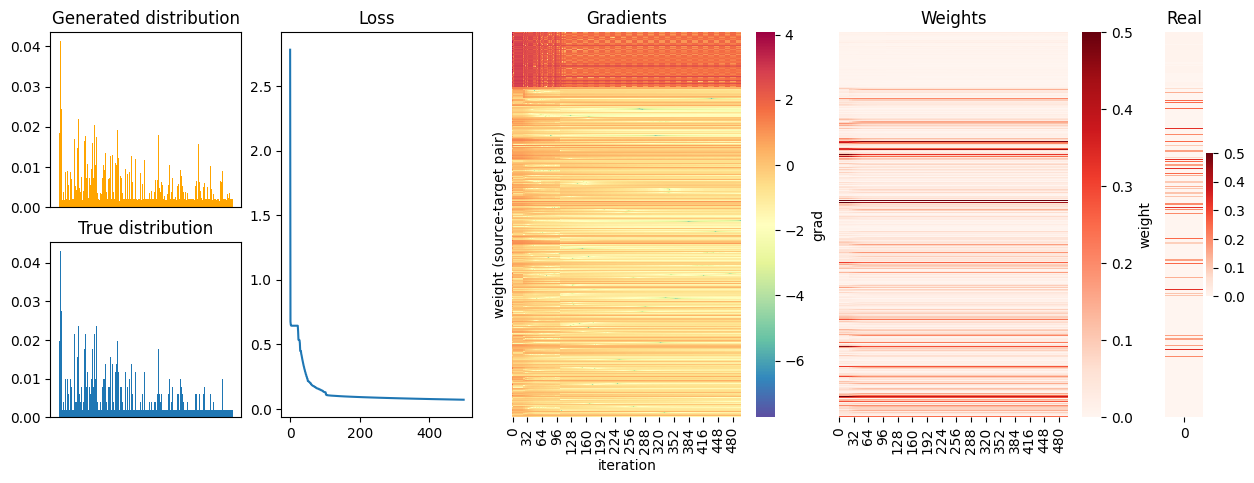

In [106]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

lr_scheduler = {}
steps = [20, 50, 100, 400, 500]
lrs = [1, 0.1, 0.01, 0.001, 0.001]
for lr, step in zip(lrs, steps):
    for i in range(step):
        if i not in lr_scheduler:
            lr_scheduler[i] = lr


wegd = WeightEstimatorGD(lr=0.1, n_iterations=500, lr_scheduler=lr_scheduler, lam1=0)
G = wegd.run(P, verbose=True)

wegd.plot(P, ps.format_graph())

In [107]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes_mc(ps.format_graph(), N_particles=10000)
get_disassembly(P, real_disassembly_indexes)


 Averaged DI: 1.75


5.693133446541452

In [108]:
from disassembly.disassembly import get_disassembly_indexes_mc

mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(P, mc_di)


 Averaged DI: 2.79


17.26497795079681

Text(0.5, 0.98, 'Disassembly indexes')

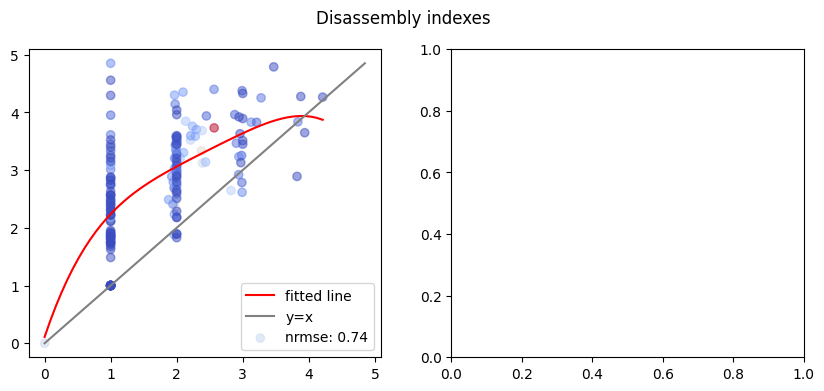

In [109]:
from scipy.stats import linregress
import numpy as np

# fig, axs = plt.subplots(1,3, figsize=(12,4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
trues = []
ys_e = []
ys_mc = []
c = []


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed) ** 2))
    nrmse = rmse / np.mean(true)
    return nrmse


for key in P.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))
    # ys_e.append((estimated_disassembly_indexes[key]))
    ys_mc.append(mc_di[key])
    c.append(P[key])
a = 0
# for xs, ys in [(trues, ys_e), (trues, ys_mc), (ys_e, ys_mc)]:
for xs, ys in [(trues, ys_mc)]:
    regress = np.polyfit(xs, ys, 4)
    nrmse = get_nrmse(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress[0] * np.linspace(0, max(xs)) ** 4
        + regress[1] * np.linspace(0, max(xs)) ** 3
        + regress[2] * np.linspace(0, max(xs)) ** 2
        + regress[3] * np.linspace(0, max(xs))
        + regress[4],
        label="fitted line",
        color="red",
    )
    axs[a].plot(
        np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x"
    )
    axs[a].scatter(xs, ys, label=f"nrmse: {nrmse:.2f}", c=c, cmap="coolwarm", alpha=0.5)
    axs[a].legend()
    a += 1

plt.suptitle("Disassembly indexes")